In [1]:
import numpy as np
from numpy.linalg import cholesky

In [2]:
def cov_mat(f, t_vec):
    """
    Produce the covariance matrix for the given autocorreltion function

    :param f: The autocorrelation function of the noise (with fitted parameters)
    :param t_vec: The time series vector
    :return: The covariance matrix for the given autocorrelation function
    """

    return [[f(abs(t1 - t2)) for t2 in t_vec] for t1 in t_vec]

In [11]:
def multivariate_normal(vec, t_vec, f):
    """
    Create a noise sampled from multivariate gaussian.
    When the autocorrelation function of the noise is known.

    :param vec: noise will be added to this vector
    :param t_vec: The time series vector (noise is correlated in time)
    :param f: The autocorrelation function of the noise (with fitted parameters)
    :return: vec with noise
    """

    # Generate noise sampled from standard normal pdf
    noise = np.random.normal(size=len(vec))

    # Decompose covariance matrix
    # And return noise with given correlation
    covmat = cov_mat(f=f, t_vec=t_vec)
    noise = np.dot(cholesky(covmat), noise)
    return np.add(vec, noise)

In [4]:
from neuron import h, gui

def exp_model(Ra=157.3621, gpas=0.000403860792, cm=7.849480, dt=0.1):
    # -- Biophysics --
    # Sec parameters and conductance
    for sec in h.allsec():
        sec.Ra = Ra  # Ra is a parameter to infer
        sec.cm = cm   # parameter optimisation algorithm found this
        sec.v = 0

        sec.insert('pas')
        sec.g_pas = gpas  # gpas is a parameter to infer
        sec.e_pas = 0

    # Print information
    #h.psection()

    # Stimulus
    stim1 = h.IClamp(h.soma(0.01))
    stim1.delay = 200
    stim1.amp = 0.5
    stim1.dur = 2.9

    stim2 = h.IClamp(h.soma(0.01))
    stim2.delay = 503
    stim2.amp = 0.01
    stim2.dur = 599.9

    # Run simulation ->
    # Set up recording Vectors
    v_vec = h.Vector()  # Membrane potential vector
    t_vec = h.Vector()  # Time stamp vector
    v_vec.record(h.soma(0.5)._ref_v)
    t_vec.record(h._ref_t)

    # Simulation duration and RUN
    h.tstop = 1200  # Simulation end
    h.dt = dt  # Time step (iteration)
    h.steps_per_ms = 1 / dt
    h.v_init = 0
    h.finitialize(h.v_init)

    h.init()
    h.run()

    t = t_vec.to_python()
    v = v_vec.to_python()

    return t, v


# --- Load NEURON morphology
h('load_file("/Users/Dani/TDK/parameter_estim/exp/morphology_131117-C2.hoc")')
# Set the appropriate "nseg"
for sec in h.allsec():
    sec.Ra = 160
h('forall {nseg = int((L/(0.1*lambda_f(100))+.9)/2)*2 + 1}')  # If Ra_max = 105 dend.nseg = 21 and soma.nseg = 1

1

In [5]:
t, v = exp_model()

In [13]:
from math import exp
def autocorrelation_function(x):
    D = 4.55090676e-01
    lamb = 2.82009826e-02
    A = 5.89036519e-03
    mu = 1.28340772e+02
    sig = 7.38233398e+01
    return D*lamb*exp(-lamb*abs(x)) - A*exp(-(abs(x)-mu)**2/(2*sig**2))

In [7]:
# Check method for exponentially correlated colored noise
def exp_corr(x):
    D = 0.22540898
    lamb = 0.06061858
    return D*lamb*np.exp(-abs(x)*lamb)

In [ ]:
v_noised = multivariate_normal(v, t, autocorrelation_function)

In [8]:
v_colornoised = multivariate_normal(v,t,exp_corr)

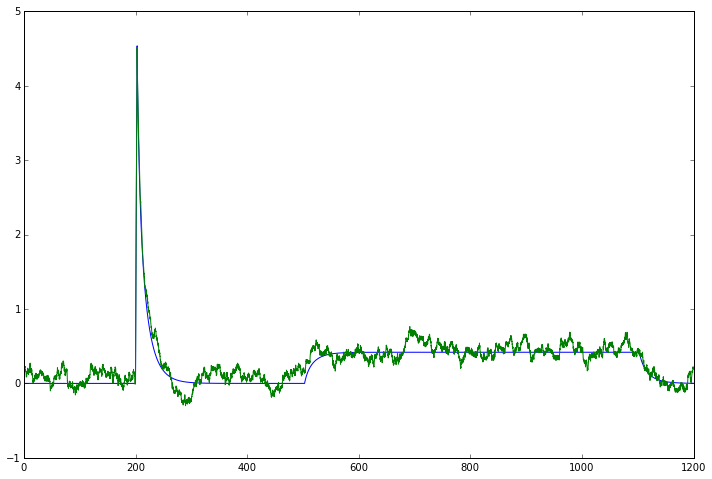

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(t, v)
plt.plot(t, np.add(v,v_colornoised))

Láthatóan exponenciális zajra szépen működik a módszer, habár sokkal lassabb a generálása.


# 2. Transzformáljuk a legközelebbi pozitív definit mátrixszá
Mivel az új illesztett autokorrelácios függvénnyel konstruált kovarianciamátrix nem lett pozitív definit, ezért keressük meg a hozzá legközelebbi ilyen típusú mátrixot és generáljunk azzal zajt.

In [14]:
def near_psd(x, epsilon=0):
    """
    Calculates the nearest positive semi-definite matrix for a correlation/covariance matrix

    :param x : array_like
    Covariance/correlation matrix
    :param epsilon : float
    Eigenvalue limit (usually set to zero to ensure positive definiteness)

    :return:
    near_cov : array_like
    closest positive definite covariance/correlation matrix
    """

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    # Removing scaling factor of covariance matrix
    n = x.shape[0]
    var_list = np.array([np.sqrt(x[i,i]) for i in xrange(n)])
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])

    # getting the nearest correlation matrix
    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape(n))))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape(n))
    near_corr = B*B.T

    # returning the scaling factors
    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])
    return near_cov

In [23]:
# Override this function to return only positive definit matrix
def cov_mat(f, t_vec):
    """
    Produce the covariance matrix for the given autocorrelation function

    :param f: The autocorrelation function of the noise (with fitted parameters)
    :param t_vec: The time series vector
    :return: The covariance matrix for the given autocorrelation function. If the matrix is not positive definit,
             then returns the nearest positive definit matrix.
    """
    
    covmat = [[f(abs(t_vec[t1] - t_vec[t2])) for t2 in xrange(len(t_vec))] for t1 in xrange(len(t_vec))]
    
    return near_psd(np.array(covmat))

In [24]:
v_noised = multivariate_normal(v, t, autocorrelation_function)

LinAlgError: Matrix is not positive definite

# Összegzés

Ha a tozított korrelációt néznénk önmagában, az pozitív definit mátrixot generálna, viszont mi az átlagára illesztünk egy függvényt, ami nem biztos hogy ilyen típusú kovarianciamátrixot generál. Ahhoz, hogy egy megfelelő tulajdonságú zajmodell konstruáljunk hosszabb adatsorra van szükségünk: hogy cseng le a zaj?

Azt várjuk, ha ismert lesz a zaj lecsengése, akkor a megfelelő modellt illesztve az teljesíteni fogja a pozitív definitség feltételét (akkor fogadjuk el helyes zajmodellként).